<a href="https://colab.research.google.com/github/hodades/ECG-Based-Arrhythmia-Classification-Using-Deep-Learning-with-Convolutional-Neural-Networks-CNN-/blob/main/ECG_Arrhythmia_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ECG Arrhythmia Classification

The heart’s activity can be measured using a test called an ECG (Electrocardiogram). It shows the electrical signals of the heart and helps doctors understand if the heart is working normally. Sometimes, the heart beats in an irregular way, called an arrhythmia. Some arrhythmias are harmless, while others can be dangerous and need immediate treatment.

Doctors usually check ECG results manually, but this process can take a lot of time and may not always catch small problems. Using machine learning, we can create a program to automatically find these irregular heartbeats faster and more accurately.

#=> What is the Goal?


We want to use machine learning to:

Analyze ECG data (heart signals).
Automatically classify the data into types of heartbeats:

N (Normal): A regular heartbeat.

VEB: A specific type of irregular heartbeat.

SVEB: Another type of irregular heartbeat.

F: A mix of normal and irregular beats.

Q: Beats that don’t fit any category (ignored because there are very few examples).

The program will help doctors by quickly and accurately identifying irregular heartbeats.

# Challenges



1. **Imbalanced Data**: Most of the data is for normal heartbeats, while some types of arrhythmias have very few examples. This makes it harder for the program to learn about the rare types.
2. **Complexity**: The heart’s signals are complicated, and small differences in the data can mean different types of arrhythmias. The program must be smart enough to detect these small differences.
3. **Real-Life Impact**: The program needs to work well on new, unseen data. If it makes a mistake, it could miss a dangerous arrhythmia, which could harm patients.


## Why Does This Matter?


This program can:
- **Save Time**: Doctors can focus on treating patients instead of spending hours reviewing ECGs.
- **Improve Accuracy**: The program can catch patterns that doctors might miss.
- **Help More People**: It can make heart diagnosis faster and more affordable, especially in areas with fewer doctors.

By solving this problem, we’re creating a tool that can help save lives and make healthcare better for everyone.

## 1. Import Libraries

We begin by importing the necessary libraries for data manipulation, machine learning, and evaluation.

In [123]:
!pip install optuna


In [124]:
pip install optuna


In [125]:
!pip install catboost


In [126]:
pip install catboost


In [127]:
import optuna
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

#Preliminary Dataset Loading

##2. Load and Explore the Dataset
The dataset is loaded from a CSV file, and initial exploration is performed to understand its structure and contents.

In [128]:
df = pd.read_csv('/content/MIT-BIH Arrhythmia Database.csv')
df.head()


,record,type,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,...,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4
0,101,N,76,313.0,0.074347,-0.160548,1.036401,-0.285662,-0.026824,41,...,0.025930,2,18,22,2,0.025930,0.025930,0.025930,0.025436,0.025436
1,101,N,313,315.0,-0.052079,-0.264784,0.886597,-0.366298,-0.059710,21,...,-0.042009,26,27,62,9,-0.042009,-0.029498,0.005012,0.030892,0.002986
2,101,N,315,321.0,-0.062151,-0.296983,0.991859,-0.410306,-0.065686,22,...,0.009528,3,8,12,1,0.009528,0.009528,0.008786,0.008786,0.008368
3,101,N,321,336.0,-0.063322,-0.281386,1.034903,-0.403880,-0.071750,22,...,-0.020536,6,9,16,1,-0.020536,-0.020257,-0.018965,-0.016968,-0.014555
4,101,N,336,344.0,-0.062915,1.046914,1.046408,1.046408,-0.074639,11,...,0.016053,16,5,31,10,0.016053,0.006742,0.002782,-0.007798,-0.051155


##3. Exploratory Data Analysis

In [129]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100689 entries, 0 to 100688
Data columns (total 34 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   record          100689 non-null  int64  
 1   type            100689 non-null  object 
 2   0_pre-RR        100689 non-null  int64  
 3   0_post-RR       100689 non-null  float64
 4   0_pPeak         100689 non-null  float64
 5   0_tPeak         100689 non-null  float64
 6   0_rPeak         100689 non-null  float64
 7   0_sPeak         100689 non-null  float64
 8   0_qPeak         100689 non-null  float64
 9   0_qrs_interval  100689 non-null  int64  
 10  0_pq_interval   100689 non-null  int64  
 11  0_qt_interval   100689 non-null  int64  
 12  0_st_interval   100689 non-null  int64  
 13  0_qrs_morph0    100689 non-null  float64
 14  0_qrs_morph1    100689 non-null  float64
 15  0_qrs_morph2    100689 non-null  float64
 16  0_qrs_morph3    100689 non-null  float64
 17  0_qrs_morp

In [130]:
df.describe()


,record,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,0_pq_interval,...,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4
count,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,...,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000
mean,173.730984,279.400947,278.588207,0.049772,0.372262,1.054485,-0.134376,-0.090466,28.326858,10.972817,...,-0.321359,11.212347,10.487163,36.112922,14.413412,-0.321359,-0.317836,-0.308809,-0.294919,-0.366798
std,51.673158,81.915453,81.124963,0.168789,0.739879,0.617508,1.027590,0.189436,15.027789,9.468930,...,0.447444,12.043096,8.799687,17.419760,9.118872,0.447444,0.456949,0.518043,0.593426,0.584913
min,100.000000,11.000000,6.000000,-3.094391,-2.006422,-2.372835,-3.622550,-3.871359,0.000000,1.000000,...,-5.481982,0.000000,1.000000,5.000000,1.000000,-5.481982,-4.493784,-4.398122,-4.069726,-4.520327
25%,115.000000,230.000000,230.000000,-0.054749,-0.249060,0.754047,-0.781784,-0.133274,18.000000,5.000000,...,-0.529435,3.000000,5.000000,25.000000,10.000000,-0.529435,-0.537288,-0.603469,-0.622269,-0.673902
50%,203.000000,267.000000,266.000000,0.015865,0.240303,1.105142,-0.516340,-0.069539,27.000000,7.000000,...,-0.111843,7.000000,8.000000,33.000000,12.000000,-0.111843,-0.115650,-0.151890,-0.196801,-0.262222
75%,219.000000,324.000000,322.000000,0.125809,0.928176,1.424135,0.857247,-0.014636,38.000000,16.000000,...,-0.028438,18.000000,13.000000,45.000000,17.000000,-0.028438,-0.016348,0.016088,0.040575,-0.052769
max,234.000000,2114.000000,2114.000000,3.821118,4.118327,4.018918,4.018918,3.080710,170.000000,150.000000,...,4.033554,260.000000,185.000000,412.000000,215.000000,4.033554,3.585718,2.691557,3.755566,2.869186


Check for Missing Values

In [131]:
print(df.isnull().sum())

record            0
type              0
0_pre-RR          0
0_post-RR         0
0_pPeak           0
0_tPeak           0
0_rPeak           0
0_sPeak           0
0_qPeak           0
0_qrs_interval    0
0_pq_interval     0
0_qt_interval     0
0_st_interval     0
0_qrs_morph0      0
0_qrs_morph1      0
0_qrs_morph2      0
0_qrs_morph3      0
0_qrs_morph4      0
1_pre-RR          0
1_post-RR         0
1_pPeak           0
1_tPeak           0
1_rPeak           0
1_sPeak           0
1_qPeak           0
1_qrs_interval    0
1_pq_interval     0
1_qt_interval     0
1_st_interval     0
1_qrs_morph0      0
1_qrs_morph1      0
1_qrs_morph2      0
1_qrs_morph3      0
1_qrs_morph4      0
dtype: int64


In [132]:
print(df['type'].value_counts())

type
N       90083
VEB      7009
SVEB     2779
F         803
Q          15
Name: count, dtype: int64


Class Distribution



type
N       90083
VEB      7009
SVEB     2779
F         803
Q          15
Name: count, dtype: int64


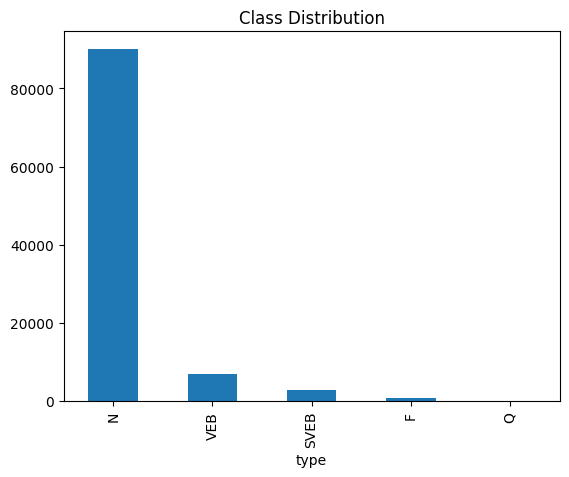

In [133]:
print(df['type'].value_counts())
df['type'].value_counts().plot(kind='bar', title='Class Distribution')
plt.show()


##4.Data Prepocessing
The dataset is preprocessed to prepare it for model training.

Remove Unnecessary Columns: The record column is dropped.
Drop Rare Classes: Rows with type = 'Q' are removed.
Encode Target Labels: type is encoded with numerical labels.
Split Data: Data is divided into training, validation, and test sets

In [134]:
# I'm dropping 'record' column since it doesn't add predictive power
df = df.drop(columns=['record'])

# Drop rows where 'type' is 'Q', too few rows...
df = df[df['type'] != 'Q']

label_encoder = LabelEncoder()
df['type'] = label_encoder.fit_transform(df['type'])

<ipython-input-134-6ed41d18ef9e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['type'] = label_encoder.fit_transform(df['type'])


In [135]:
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

{'F': 0, 'N': 1, 'SVEB': 2, 'VEB': 3}


In [136]:
X = df.drop('type', axis=1)
y = df['type']

In [137]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

##5. Baseline Models
###5.1 XGBoost

In [138]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', verbosity=0, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_val)
print("XGBoost Classification Report:")
print(classification_report(y_val, y_pred_xgb, target_names=label_encoder.classes_))


XGBoost Classification Report:
              precision    recall  f1-score   support

           F       0.93      0.84      0.88       121
           N       0.99      1.00      1.00     13512
        SVEB       0.95      0.89      0.92       417
         VEB       0.98      0.98      0.98      1051

    accuracy                           0.99     15101
   macro avg       0.96      0.93      0.94     15101
weighted avg       0.99      0.99      0.99     15101



### 5.2 CatBoost

In [139]:
cat_model = CatBoostClassifier(verbose=0, random_state=42)
cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_val)
print("CatBoost Classification Report:")
print(classification_report(y_val, y_pred_cat, target_names=label_encoder.classes_))


CatBoost Classification Report:
              precision    recall  f1-score   support

           F       0.94      0.84      0.89       121
           N       0.99      1.00      1.00     13512
        SVEB       0.96      0.87      0.91       417
         VEB       0.97      0.98      0.98      1051

    accuracy                           0.99     15101
   macro avg       0.97      0.92      0.94     15101
weighted avg       0.99      0.99      0.99     15101



### 5.3 LightGBM

In [140]:
lgbm_model = LGBMClassifier(verbosity=-1, random_state=42)
lgbm_model.fit(X_train, y_train)
y_pred_lgbm = lgbm_model.predict(X_val)
print("LightGBM Classification Report:")
print(classification_report(y_val, y_pred_lgbm, target_names=label_encoder.classes_))


LightGBM Classification Report:
              precision    recall  f1-score   support

           F       0.92      0.80      0.86       121
           N       0.99      1.00      1.00     13512
        SVEB       0.96      0.87      0.91       417
         VEB       0.98      0.98      0.98      1051

    accuracy                           0.99     15101
   macro avg       0.96      0.91      0.94     15101
weighted avg       0.99      0.99      0.99     15101



###6. Soft Ensemble Model
An ensemble model combines predictions from XGBoost, CatBoost, and LightGBM for improved performance.

In [145]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 400),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.3),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5)
    }

    model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', **params, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, n_jobs=-1)

print("Best Hyperparameters for XGBoost (Optuna):")
print(study.best_params)

best_xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    **study.best_params,
    random_state=42
)
best_xgb_model.fit(X_train, y_train)

[I 2025-01-08 15:27:16,881] A new study created in memory with name: no-name-9470be09-e6e6-42e8-8060-0b23cefff7dd
[W 2025-01-08 15:27:16,924] Trial 0 failed with parameters: {'n_estimators': 179, 'max_depth': 8, 'learning_rate': 0.15866623570162536, 'subsample': 0.949998013825617, 'colsample_bytree': 0.8612574176119181, 'gamma': 0.29107139233660934, 'min_child_weight': 2} because of the following error: AttributeError("'super' object has no attribute '__sklearn_tags__'").
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-145-1d2db2d202cc>", line 13, in objective
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selectio

AttributeError: 'super' object has no attribute '__sklearn_tags__'